# Gradient Boosting

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer


##Solo se va a implementar para regresión y para clasificación binaria con clases igual a -1 y +1

In [2]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()
    
def plotModel(x,y,clase,clf,title=""):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    elif hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==0], y[clase==0], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==0],y[c==0],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

In [3]:
class SquaredErrorLoss:
    """ Clase que define elementos para la función cuadrática de perdida 
        para regresión """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        return np.mean(y)

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return y - F

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja del árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado al arbol regresor ht
           Además recibe el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        # Los multiplicadores son 1, luego el valor de la hoja no se actualiza
        return valor
    
    def predict(_, y):
        return y
    
    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return 0.5*(y-F)**2
    
class LogLoss:
    """ Clase que define elementos para la función logística de perdida 
        para clasificación de dos clases {-1, +1} """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        y_mean = np.mean(y)
        return 0.5*np.log((1.0+y_mean)/(1.0-y_mean))

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return 2.0*y/(1+np.exp(2.0*y*F))

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        residuos_abs = np.abs(residuos)
        try:
            return np.sum(residuos)/np.sum(residuos_abs*(2.0-residuos_abs))
        except ZeroDivisionError:
            return 0.0
    
    def predict(_, y):
        return 2*((1.0/(1.0 + np.exp(-2 * y))) >= 0.5) - 1
        

    def __call__(self,y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return np.log(1+np.exp(-2.0*y*F))
    
class GBCasero:
    def __init__(self, n_estimators=101, loss=SquaredErrorLoss(), eta=0.1, depth=3):
        self.n_estimators = n_estimators
        self._estimators  = []
        self.depth        = depth
        self.eta          = eta
        # La implementación de loss se usará en fit para crear el algoritmo
        # GB de forma genérica.
        self.loss         = loss
    
    def fit(self,X,y):
        """
          Inicializa GB 
        """
        class F0:
            predict = lambda x: self.loss.F0(X, y)
        self._estimators.append(F0)
        
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth = self.depth)
            """
              Rellenar esta parte para implementar GB 
              Se debe utilizar la función paso_newton de abajo
            """
            residuos = self.loss.residuos(y, self.predict(X))
            tree = tree.fit(X, residuos)
            self.paso_newton_general(tree, X, y, residuos)
            self._estimators.append(tree)
            
    def predict(self,X):
        """ Combinamos los valores de pesos y hs para obtener la 'salida', y:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable """
        
        salida = sum(i.predict(X)*self.eta for i in self._estimators)
        return self.loss.predict(salida)   
            
    def paso_newton_general(self, tree, X, y, residuos):
        """ Esta función actualiza todas las hojas de salida
            del árbol 'tree' utilizado la función paso_newton_hoja
            de las clases de funcion de pérdida """
        TREE_LEAF = -1
        tree = tree.tree_
        self.leaf_indices = tree.apply(np.array(X,dtype=np.float32))
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            ii = self.leaf_indices==leaf
            tree.value[leaf,0,0] = self.loss.paso_newton_hoja(y[ii],
                                                              residuos[ii],
                                                              tree.value[leaf,0,0])



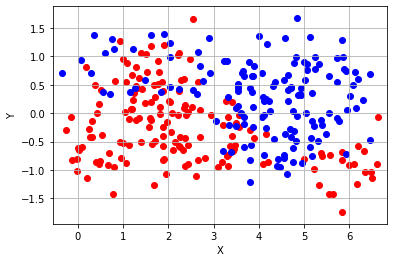

In [4]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.3             # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x1, x2, ytrain, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
x1test, x2test, ytest = createDataSet(n*10, model, ymargin, noise)
plotData(x1,x2,ytrain,{'c':'#FF0000'},{'c':'#0000FF'})
Xtrain = np.concatenate((x1, x2), axis = 1)
Xtest = np.concatenate((x1test, x2test), axis = 1)

Accuracy in Data example = 0.8536666666666667


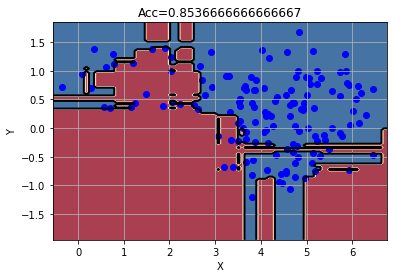

In [5]:
# Basic example
gb = GBCasero(loss=LogLoss())

lb     = LabelBinarizer(pos_label = 1, neg_label = -1)
ytrain = lb.fit_transform(ytrain).ravel()
ytest  = lb.transform(ytest).ravel()
gb.fit(Xtrain, ytrain)
acc = np.sum(gb.predict(Xtest)==ytest)/len(ytest)

print("Accuracy in Data example =",acc)
plotModel(x1,x2,ytrain,gb,"Acc="+str(acc))

In [6]:
# Magic
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')

X_tr, X_ts, y_tr, y_ts = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], 
                                          test_size=0.8, random_state=1)
lb   = LabelBinarizer(pos_label = 1, neg_label = -1)
y_tr = lb.fit_transform(y_tr).ravel()
y_ts = lb.transform(y_ts).ravel()

gb = GBCasero(loss=LogLoss())
gb.fit(X_tr, y_tr)

print("Accuracy in Magic04 =",np.sum(gb.predict(X_ts)==y_ts)/len(y_ts))

Accuracy in Magic04 = 0.8521950578338591


In [7]:
## Para comparativas

import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skpp
import timeit
from sklearn.svm import SVC

n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 300 # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
#clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
#clf = tree.DecisionTreeClassifier()
clf = RandomForestClassifier(n_estimators=100)  # <================== Modificar 100 o 1000

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(indices_train),(toc - tic)/n_executions))

n_executions = 10

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 100.
print("Tiempo de clasificar {:g} ejemplos: {:.4g} s.".format(factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 300 ejemplos: 0.1374 s.
Tiempo de clasificar 100 ejemplos: 0.002953 s.
